In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
import os
import json
import re
import random
import csv
# install bitsandbytes and restart

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def get_dataset(path):
  with open(path, 'r', encoding='utf-8') as f:
    data = json.load(f)
  filtered_data = [
      {'prompt': f'{entry['story']} {entry['question']}', 'belief': 1 if entry['belief'] else 0}
      for entry in data
  ]
  return filtered_data

In [4]:
tomi = get_dataset("/content/drive/MyDrive/SEF/Data/ToMi/tomi_all.json")
bigtom = get_dataset("/content/drive/MyDrive/SEF/Data/BigToM/bigtom_all.json")

In [5]:
model_id = "mistralai/Mistral-7B-v0.1"
tokenizer = AutoTokenizer.from_pretrained(model_id, padding=True, truncation=True, model_max_length=512)
tokenizer.padding_side = "right"
tokenizer.truncation_side = "right"

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_config,
    dtype=torch.float16,
)
model.eval()

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): MistralRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

# Extract Last-Token Activation Vectors


In [6]:
num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads
head_dim = model.config.hidden_size

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
def extract_activations(prompts, batch_size=8):
  all_hidden_states = []
  for i in range(0, len(prompts), batch_size):
    batch_prompts = prompts[i:i+batch_size]
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
      outputs = model(**inputs, output_hidden_states=True, attn_implementation="eager")

    hidden_states = outputs.hidden_states[1:]

    attention_mask = inputs["attention_mask"]  # (bs, seq_len)
    lengths = attention_mask.sum(dim=1) - 1     # index of last real token
    batch_last_hidden = []
    for layer_hs in hidden_states:
        # layer_hs: (bs, seq_len, hidden)
        last_tokens = layer_hs[torch.arange(layer_hs.size(0)), lengths]
        batch_last_hidden.append(last_tokens)

    batch_last_hidden = torch.stack(batch_last_hidden, dim=1)
    all_hidden_states.append(batch_last_hidden.cpu())

  global_all_hidden = torch.cat(all_hidden_states, dim=0)

  return global_all_hidden


In [9]:
tomi_prompts = [entry['prompt'] for entry in tomi]
bigtom_prompts = [entry['prompt'] for entry in bigtom]

last_token_hidden_tomi = extract_activations(tomi_prompts)
last_token_hidden_bigtom = extract_activations(bigtom_prompts)

# Extract Mean-Pooled Activations

In [10]:
def extract_mean_pooled_hidden(prompts, batch_size=8):
  all_pooled = []
  for i in range(0, len(prompts), batch_size):
    batch = prompts[i:i+batch_size]
    inputs = tokenizer(
        batch,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
      outputs = model(**inputs, output_hidden_states=True)

    hidden_states = outputs.hidden_states[1:]
    attention_mask = inputs["attention_mask"] # [bs, seq_len]
    mask = attention_mask.unsqueeze(-1)
    lengths = attention_mask.sum(dim=1).unsqueeze(-1)

    pooled_layers = []
    for hs in hidden_states:
        # hs: [bs, seq_len, hidden_dim]
        masked_sum = (hs * mask).sum(dim=1)     # [bs, hidden_dim]
        mean_pooled = masked_sum / lengths      # [bs, hidden_dim]
        pooled_layers.append(mean_pooled)

    # Stack layers: [bs, num_layers, hidden_dim]
    batch_pooled = torch.stack(pooled_layers, dim=1)
    all_pooled.append(batch_pooled.cpu())

  return torch.cat(all_pooled, dim=0)

In [11]:
mean_pooled_tomi = extract_mean_pooled_hidden(tomi_prompts)
mean_pooled_bigtom = extract_mean_pooled_hidden(bigtom_prompts)

# Train Linear Probes

In [12]:
for param in model.parameters():
    param.requires_grad = False

In [13]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [14]:
def train_layerwise_probes(
    last_token_hidden,
    labels,
    test_size = 0.2,
    random_state=42,
    max_iter=1000
):
  X = last_token_hidden.cpu().numpy()
  y = np.asarray(labels).astype(int)
  N, num_layers, d = X.shape
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=test_size, stratify=y, random_state=random_state
  )
  results = {
      'accuracy': [],
      'auc': [],
      'weights': [],
      'biases': [],
  }

  for layer in range(num_layers):
    # extract activations for this layer
    X_train_l = X_train[:, layer, :]
    X_test_l = X_test[:, layer, :]
    probe = LogisticRegression(
        penalty="l2",
        C = 1.0,
        solver = "lbfgs",
        max_iter=max_iter
    )
    probe.fit(X_train_l, y_train)

    y_pred = probe.predict(X_test_l)
    y_prob = probe.predict_proba(X_test_l)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results['accuracy'].append(acc)
    results['auc'].append(auc)
    results['weights'].append(probe.coef_[0])
    results['biases'].append(probe.intercept_[0])

  return results


In [15]:
def crossval_layerwise_probes(
    activations, labels, n_splits=5, random_state=42, max_iter=1000
):
    X = activations.cpu().numpy()
    y = np.asarray(labels).astype(int)
    N, num_layers, d = X.shape
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    accs = np.zeros((n_splits, num_layers))
    aucs = np.zeros((n_splits, num_layers))
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        for layer in range(num_layers):
            X_train_l = X_train[:, layer, :]
            X_test_l = X_test[:, layer, :]
            probe = LogisticRegression(
                penalty="l2", C=1.0, solver="lbfgs", max_iter=max_iter
            )
            probe.fit(X_train_l, y_train)
            y_pred = probe.predict(X_test_l)
            y_prob = probe.predict_proba(X_test_l)[:, 1]
            accs[fold, layer] = accuracy_score(y_test, y_pred)
            aucs[fold, layer] = roc_auc_score(y_test, y_prob)
    return accs, aucs

In [16]:
tomi_labels = [entry['belief'] for entry in tomi]
bigtom_labels = [entry['belief'] for entry in bigtom]

In [17]:
tomi_accs, tomi_aucs = crossval_layerwise_probes(mean_pooled_tomi, tomi_labels)
bigtom_accs, bigtom_aucs = crossval_layerwise_probes(mean_pooled_bigtom, bigtom_labels)

In [18]:
print("ToMi 5-fold CV mean accuracy per layer:", tomi_accs.mean(axis=0))
print("BigToM 5-fold CV mean accuracy per layer:", bigtom_accs.mean(axis=0))
print("ToMi 5-fold CV mean AUC per layer:", tomi_aucs.mean(axis=0))
print("BigToM 5-fold CV mean AUC per layer:", bigtom_aucs.mean(axis=0))
print("ToMi overall mean accuracy:", tomi_accs.mean())
print("BigToM overall mean accuracy:", bigtom_accs.mean())

ToMi 5-fold CV mean accuracy per layer: [0.6   0.585 0.595 0.6   0.605 0.61  0.62  0.63  0.64  0.62  0.625 0.645
 0.655 0.67  0.665 0.665 0.67  0.675 0.655 0.655 0.64  0.62  0.62  0.63
 0.63  0.6   0.63  0.615 0.635 0.63  0.605 0.585]
BigToM 5-fold CV mean accuracy per layer: [0.475 0.525 0.52  0.53  0.495 0.545 0.555 0.505 0.515 0.51  0.495 0.5
 0.47  0.475 0.43  0.45  0.455 0.44  0.48  0.47  0.455 0.465 0.46  0.48
 0.455 0.45  0.44  0.445 0.465 0.465 0.455 0.44 ]
ToMi 5-fold CV mean AUC per layer: [0.635  0.6255 0.627  0.627  0.634  0.6355 0.637  0.6465 0.659  0.663
 0.677  0.699  0.7145 0.727  0.7275 0.7235 0.724  0.728  0.72   0.7105
 0.6965 0.69   0.688  0.6835 0.678  0.675  0.674  0.6675 0.6745 0.662
 0.6525 0.617 ]
BigToM 5-fold CV mean AUC per layer: [0.48475 0.52425 0.52275 0.52475 0.52375 0.51925 0.52525 0.50475 0.48575
 0.48775 0.48175 0.47675 0.46675 0.46175 0.44925 0.45875 0.44125 0.43825
 0.45425 0.45725 0.44625 0.45725 0.44775 0.45275 0.45225 0.44475 0.44675
 0.44775 0.4

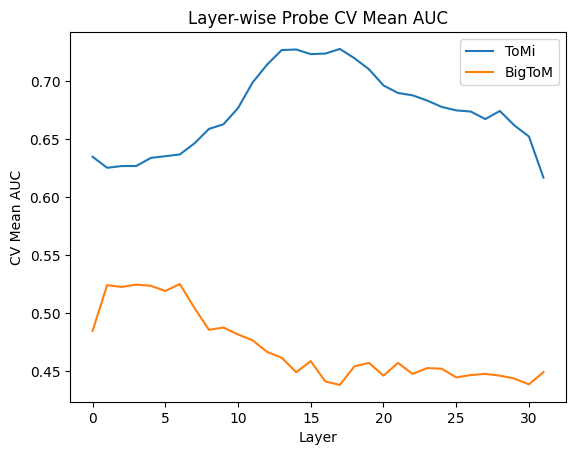

In [22]:
import matplotlib.pyplot as plt

plt.plot(tomi_aucs.mean(axis=0), label="ToMi")
plt.plot(bigtom_aucs.mean(axis=0), label="BigToM")
plt.xlabel("Layer")
plt.ylabel("CV Mean AUC")
plt.legend()
plt.title("Layer-wise Probe CV Mean AUC")
plt.show()

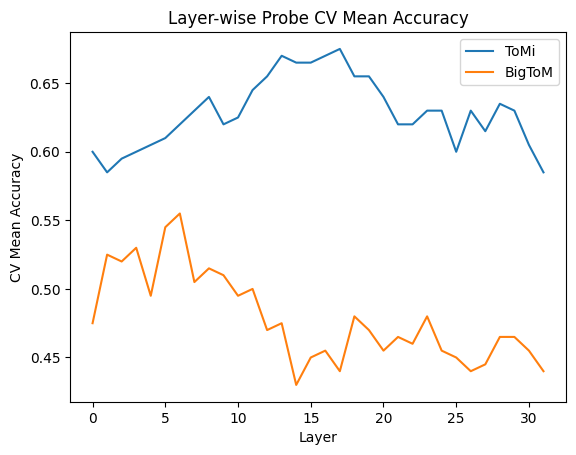

In [23]:
import matplotlib.pyplot as plt

plt.plot(tomi_accs.mean(axis=0), label="ToMi")
plt.plot(bigtom_accs.mean(axis=0), label="BigToM")
plt.xlabel("Layer")
plt.ylabel("CV Mean Accuracy")
plt.legend()
plt.title("Layer-wise Probe CV Mean Accuracy")
plt.show()

In [24]:
best_tomi_layer = np.argmax(tomi_accs.mean(axis=0))
best_bigtom_layer = np.argmax(bigtom_accs.mean(axis=0))

tomi_X = mean_pooled_tomi[:, best_tomi_layer, :].cpu().numpy()
bigtom_X = mean_pooled_bigtom[:, best_bigtom_layer, :].cpu().numpy()
tomi_y = np.array(tomi_labels)
bigtom_y = np.array(bigtom_labels)

tomi_X_train, tomi_X_test, tomi_y_train, tomi_y_test = train_test_split(
    tomi_X, tomi_y, test_size=0.2, stratify=tomi_y, random_state=42
)
bigtom_X_train, bigtom_X_test, bigtom_y_train, bigtom_y_test = train_test_split(
    bigtom_X, bigtom_y, test_size=0.2, stratify=bigtom_y, random_state=42
)

# 3. Train final probe on train+val
final_tomi_probe = LogisticRegression(penalty="l2", C=1.0, solver="lbfgs", max_iter=1000)
final_tomi_probe.fit(tomi_X_train, tomi_y_train)

final_bigtom_probe = LogisticRegression(penalty="l2", C=1.0, solver="lbfgs", max_iter=1000)
final_bigtom_probe.fit(bigtom_X_train, bigtom_y_train)

# 4. Evaluate on test
tomi_test_acc = accuracy_score(tomi_y_test, final_tomi_probe.predict(tomi_X_test))
tomi_test_auc = roc_auc_score(tomi_y_test, final_tomi_probe.predict_proba(tomi_X_test)[:, 1])

bigtom_test_acc = accuracy_score(bigtom_y_test, final_bigtom_probe.predict(bigtom_X_test))
bigtom_test_auc = roc_auc_score(bigtom_y_test, final_bigtom_probe.predict_proba(bigtom_X_test)[:, 1])

print(f"ToMi final probe (layer {best_tomi_layer}) - Test Accuracy: {tomi_test_acc:.3f}, Test AUC: {tomi_test_auc:.3f}")
print(f"BigToM final probe (layer {best_bigtom_layer}) - Test Accuracy: {bigtom_test_acc:.3f}, Test AUC: {bigtom_test_auc:.3f}")

ToMi final probe (layer 17) - Test Accuracy: 0.625, Test AUC: 0.635
BigToM final probe (layer 6) - Test Accuracy: 0.525, Test AUC: 0.423


In [29]:
shuffled_labels = np.random.permutation([entry['belief'] for entry in tomi])
shuffled_results = train_layerwise_probes(
    last_token_hidden_tomi,
    shuffled_labels
)
print(np.mean(shuffled_results['accuracy']), np.mean(shuffled_results['auc']))

0.48828125 0.48210937499999995


In [25]:
# Save direction vectors (weights) for best layer

np.save('/content/drive/MyDrive/SEF/Data/NumPy/phase_1_tomi_weights', final_tomi_probe.coef_[0])
np.save('/content/drive/MyDrive/SEF/Data/NumPy/phase_1_bigtom_weights', final_bigtom_probe.coef_[0])
np.save('/content/drive/MyDrive/SEF/Data/NumPy/phase_1_tomi_biases', final_tomi_probe.intercept_[0])
np.save('/content/drive/MyDrive/SEF/Data/NumPy/phase_1_bigtom_biases', final_bigtom_probe.intercept_[0])